In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

module_path = (Path().resolve().parent/ "Modules")
sys.path.append(str(module_path))

import my_modules, model_tuner, features

pd.set_option("display.max_columns", None)
pd.set_option("display.max_info_columns", 100)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
df = pd.read_csv("../Data/train_data_tmp.csv", encoding="shift-jis")
odds_df = pd.read_csv("../Data/Time_Series_Odds_win_odds.csv", encoding="shift-jis")

In [16]:
df2 = my_modules.preprocessing(df)

In [17]:
df3 = my_modules.common_process(df2)

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\my_modules.py:74: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["place_num"] = df["place"].replace(place_dict).astype(int)


In [18]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252411 entries, 252634 to 0
Data columns (total 76 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   race_id              252411 non-null  int64         
 1   year                 252411 non-null  int64         
 2   month                252411 non-null  int64         
 3   day                  252411 non-null  int64         
 4   times                252411 non-null  int64         
 5   place                252411 non-null  object        
 6   daily                252411 non-null  object        
 7   race_num             252411 non-null  int64         
 8   horse                252411 non-null  object        
 9   jockey_id            252411 non-null  object        
 10  trainer_id           252411 non-null  int64         
 11  horse_N              252411 non-null  object        
 12  waku_num             252411 non-null  int64         
 13  horse_num          

In [19]:
df3.head()

,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_odds_1,win_odds_1_pop,win_odds_2,win_odds_2_pop,win_mul_odds_Hi,win_mul_odds_Lo,win_mul_odds_1_Hi,win_mul_odds_1_Lo,win_mul_odds_1_pop,win_mul_odds_2_Hi,win_mul_odds_2_Lo,win_mul_odds_2_pop,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,age_type,sample_weight,target,target3
252634,202001050601010115,2020,1,5,1,中山,1,1,ラブカワールド,1177,1131,16,8,15,7,24,2,1200,良,晴,12,牝,3,51.0,NaN,436.0,4.0,3,474.2,355.9,15,254.1,14,153.0,39.3,115.2,36.0,15,74.6,30.0,14,13,2.0,1153,NaN,NaN,15.0,16.0,39.9,9,35.4,38.7,40.57,36.0,1.5,後方,15.0,0,0,トゥザワールド,ラブカテリーナ,オレハマッテルゼ,ロイヤルチャージャー系,黒鹿,2017104350,2020010506010101,ダート,平地,R,中山ダート1200,outer,2020-01-05 01:02:00,3,0.0625,0,0
252635,202001050601010116,2020,1,5,1,中山,1,1,シラカワカツコ,1173,1031,16,8,16,7,24,2,1200,良,晴,12,牝,3,51.0,NaN,404.0,4.0,3,233.1,239.5,13,197.1,13,83.6,21.6,62.3,19.6,13,30.6,12.4,12,14,2.1,1154,NaN,NaN,9.0,10.0,40.4,13,35.0,36.6,40.57,36.0,1.1,中団,13.0,0,0,ディープブリランテ,シャイニングピサ,Smart Strike,ネイティヴダンサー系,鹿毛,2017101747,2020010506010101,ダート,平地,R,中山ダート1200,outer,2020-01-05 01:02:00,3,0.0625,0,0
252633,202001050601010102,2020,1,5,1,中山,1,1,スルーザリミッツ,1122,1118,16,1,2,7,24,2,1200,良,晴,12,牝,3,54.0,NaN,424.0,-4.0,3,31.4,31.1,7,22.6,6,13.7,3.9,11.3,3.8,7,7.4,3.2,6,12,1.6,1149,NaN,NaN,16.0,15.0,39.3,6,35.6,40.6,40.57,36.0,1.7,後方,7.0,0,0,パイロ,ファービヨンド,ディープスカイ,ロイヤルチャージャー系,黒鹿,2017101861,2020010506010101,ダート,平地,R,中山ダート1200,inner,2020-01-05 01:02:00,3,0.0625,0,0
252632,202001050601010104,2020,1,5,1,中山,1,1,セルレア,1161,1115,16,2,4,7,24,2,1200,良,晴,12,牝,3,53.0,NaN,464.0,10.0,3,14.5,15.7,4,19.5,5,7.3,2.2,6.2,2.2,5,6.1,2.7,5,11,1.6,1149,NaN,NaN,6.0,6.0,40.2,11,34.7,36.3,40.57,36.0,0.8,中団,4.0,0,0,ロードカナロア,ダイワミストレス,ダイワメジャー,ロイヤルチャージャー系,鹿毛,2017102095,2020010506010101,ダート,平地,R,中山ダート1200,inner,2020-01-05 01:02:00,3,0.0625,0,0
252631,202001050601010109,2020,1,5,1,中山,1,1,サノレーヌ,1164,1141,16,5,9,7,24,2,1200,良,晴,12,牝,3,51.0,NaN,438.0,0.0,3,9.5,8.0,3,6.8,3,4.5,1.5,3.9,1.5,3,3.1,1.5,3,10,1.5,1148,NaN,NaN,1.0,1.0,40.9,15,33.9,32.9,40.57,36.0,0.0,逃げ,3.0,0,0,サウスヴィグラス,アニマートホウヨウ,フサイチコンコルド,ニアークティック系,鹿毛,2017100847,2020010506010101,ダート,平地,R,中山ダート1200,outer,2020-01-05 01:02:00,3,0.0625,0,0


In [20]:
feature_col = ["waku_num", "horse_num", "sex", "age", "basis_weight", "weight", "inc_dec", "age_type"]
df4, feature_col2 = features.feature_engineering(df3, feature_col)

calculating trueskill of horse is in progress
calculating trueskill of jockey is in progress
calculating EloRating is in progress
calculating Glicko is in progress


<string>:181: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<string>:181: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<string>:181: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<string>:181: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['waku_num', 'horse_num', 'sex', 'age', 'basis_weight', 'weight', 'inc_dec', 'age_type', 'weight_last_1', 'weight_last_2', 'weight_last_3', 'weight_mean_last_1_to_3', 'weight_mean_all', 'inc_dec_last_1', 'inc_dec_last_2', 'inc_dec_last_3', 'inc_dec_mean_last_1_to_3', 'inc_dec_mean_all', 'last_3F_time_last_1', 'last_3F_time_last_2', 'last_3F_time_last_3', 'last_3F_time_mean_last_1_to_3', 'last_3F_time_mean_all', 'Ave_3F_last_1', 'Ave_3F_last_2', 'Ave_3F_last_3', 'Ave_3F_mean_last_1_to_3', 'Ave_3F_mean_all', 'basis_weight_per_weight', 'basis_weight_plus_weight', 'inc_dec_rate', 'lifetime_prize', 'lifetime_prize_per_race', 'is_same_field_type_as_last', 'is_same_class_code_as_last', 'is_same_jockey_as_last', 'interval_day', 'horse_TrueSkill', 'horse_TrueSkill_sigma', 'horse_TrueSkill_min', 'horse_TrueSkill_max', 'jockey_TrueSkill', 'jockey_TrueSkill_sigma', 'jockey_TrueSkill_min', 'jockey_TrueSkill_max', 'HorseTrueSkill_times_JockeyTrueSkill', 'horse_EloRating', 'jockey_EloRating', 'horse_

,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_odds_1,win_odds_1_pop,win_odds_2,win_odds_2_pop,win_mul_odds_Hi,win_mul_odds_Lo,win_mul_odds_1_Hi,win_mul_odds_1_Lo,win_mul_odds_1_pop,win_mul_odds_2_Hi,win_mul_odds_2_Lo,win_mul_odds_2_pop,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,age_type,sample_weight,target,target3,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,basis_weight_per_weight,basis_weight_plus_weight,inc_dec_rate,lifetime_prize,lifetime_prize_per_race,is_same_field_type_as_last,is_same_class_code_as_last,is_same_jockey_as_last,interval_day,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,horse_TrueSkill_after_racing,jockey_TrueSkill,jockey_TrueSkill_sigma,jockey_TrueSkill_min,jockey_TrueSkill_max,jockey_TrueSkill_after_racing,HorseTrueSkill_times_JockeyTrueSkill,horse_EloRating,horse_EloRating_after_racing,jockey_EloRating,jockey_EloRating_after_racing,horse_Glicko2,horse_Glicko2_RD,horse_Glicko2_min,horse_Glicko2_max,horse_Glicko2_after_racing,mean_horse_TrueSkill_in_group_father,mean_horse_TrueSkill_in_group_father_state,mean_horse_TrueSkill_in_group_father_state_field_type,mean_horse_TrueSkill_in_group_father_place,mean_horse_TrueSkill_in_group_father_place_turn_type,mean_horse_TrueSkill_in_group_father_place_dist,mean_horse_TrueSkill_in_group_father_place_corner_num,mean_horse_TrueSkill_in_group_father_place_field_type,mean_horse_TrueSkill_in_group_father_dist,mean_horse_TrueSkill_in_group_father_turn_type,mean_horse_TrueSkill_in_group_father_field_type,mean_horse_TrueSkill_in_group_father_jockey_id,mean_horse_TrueSkill_in_group_father_trainer_id,mean_horse_TrueSkill_in_group_father_race_type,mean_horse_TrueSkill_in_group_father_mother,mean_horse_TrueSkill_in_group_mother,mean_horse_TrueSkill_in_group_mother_state,mean_horse_TrueSkill_in_group_mother_state_field_type,mean_horse_TrueSkill_in_group_mother_place,mean_horse_TrueSkill_in_group_mother_place_turn_type,mean_horse_TrueSkill_in_group_mother_place_dist,mean_horse_TrueSkill_in_group_mother_place_corner_num,mean_horse_TrueSkill_in_group_mother_place_field_type,mean_horse_TrueSkill_in_group_mother_dist,mean_horse_TrueSkill_in_group_mother_turn_type,mean_horse_TrueSkill_in_group_mother_field_type,mean_horse_TrueSkill_in_group_mother_jockey_id,mean_horse_TrueSkill_in_group_mother_trainer_id,mean_horse_TrueSkill_in_group_mother_race_type,mean_horse_TrueSkill_in_group_broodmare_sire,mean_horse_TrueSkill_in_group_broodmare_sire_state,mean_horse_TrueSkill_in_group_broodmare_sire_state_field_type,mean_horse_TrueSkill_in_group_broodmare_sire_place,mean_horse_TrueSkill_in_group_broodmare_sire_place_turn_type,mean_horse_TrueSkill_in_group_broodmare_sire_place_dist,mean_horse_TrueSkill_in_group_broodmare_sire_place_corner_num,mean_horse_TrueSkill_in_group_broodmare_sire_place_field_type,mean_horse_TrueSkill_in_group_broodmare_sire_dist,mean_horse_TrueSkill_in_group_broodmare_sire_turn_type,mean_horse_TrueSkill_in_group_broodmare_sire_field_type,mean_horse_TrueSkill_in_group_broodmare_sire_jockey_id,mean_horse_TrueSkill_in_group_broodmare_sire_trainer_id,mean_horse_TrueSkill_in_group_broodmare_sire_race_type,mean_horse_TrueSkill_in_group_father_broodmare_sire,mean_horse_TrueSkill_in_group_father_brood

In [21]:
print(df4.shape)
df4.head()

(252411, 287)


,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_odds_1,win_odds_1_pop,win_odds_2,win_odds_2_pop,win_mul_odds_Hi,win_mul_odds_Lo,win_mul_odds_1_Hi,win_mul_odds_1_Lo,win_mul_odds_1_pop,win_mul_odds_2_Hi,win_mul_odds_2_Lo,win_mul_odds_2_pop,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,age_type,sample_weight,target,target3,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,basis_weight_per_weight,basis_weight_plus_weight,inc_dec_rate,lifetime_prize,lifetime_prize_per_race,is_same_field_type_as_last,is_same_class_code_as_last,is_same_jockey_as_last,interval_day,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,horse_TrueSkill_after_racing,jockey_TrueSkill,jockey_TrueSkill_sigma,jockey_TrueSkill_min,jockey_TrueSkill_max,jockey_TrueSkill_after_racing,HorseTrueSkill_times_JockeyTrueSkill,horse_EloRating,horse_EloRating_after_racing,jockey_EloRating,jockey_EloRating_after_racing,horse_Glicko2,horse_Glicko2_RD,horse_Glicko2_min,horse_Glicko2_max,horse_Glicko2_after_racing,mean_horse_TrueSkill_in_group_father,mean_horse_TrueSkill_in_group_father_state,mean_horse_TrueSkill_in_group_father_state_field_type,mean_horse_TrueSkill_in_group_father_place,mean_horse_TrueSkill_in_group_father_place_turn_type,mean_horse_TrueSkill_in_group_father_place_dist,mean_horse_TrueSkill_in_group_father_place_corner_num,mean_horse_TrueSkill_in_group_father_place_field_type,mean_horse_TrueSkill_in_group_father_dist,mean_horse_TrueSkill_in_group_father_turn_type,mean_horse_TrueSkill_in_group_father_field_type,mean_horse_TrueSkill_in_group_father_jockey_id,mean_horse_TrueSkill_in_group_father_trainer_id,mean_horse_TrueSkill_in_group_father_race_type,mean_horse_TrueSkill_in_group_father_mother,mean_horse_TrueSkill_in_group_mother,mean_horse_TrueSkill_in_group_mother_state,mean_horse_TrueSkill_in_group_mother_state_field_type,mean_horse_TrueSkill_in_group_mother_place,mean_horse_TrueSkill_in_group_mother_place_turn_type,mean_horse_TrueSkill_in_group_mother_place_dist,mean_horse_TrueSkill_in_group_mother_place_corner_num,mean_horse_TrueSkill_in_group_mother_place_field_type,mean_horse_TrueSkill_in_group_mother_dist,mean_horse_TrueSkill_in_group_mother_turn_type,mean_horse_TrueSkill_in_group_mother_field_type,mean_horse_TrueSkill_in_group_mother_jockey_id,mean_horse_TrueSkill_in_group_mother_trainer_id,mean_horse_TrueSkill_in_group_mother_race_type,mean_horse_TrueSkill_in_group_broodmare_sire,mean_horse_TrueSkill_in_group_broodmare_sire_state,mean_horse_TrueSkill_in_group_broodmare_sire_state_field_type,mean_horse_TrueSkill_in_group_broodmare_sire_place,mean_horse_TrueSkill_in_group_broodmare_sire_place_turn_type,mean_horse_TrueSkill_in_group_broodmare_sire_place_dist,mean_horse_TrueSkill_in_group_broodmare_sire_place_corner_num,mean_horse_TrueSkill_in_group_broodmare_sire_place_field_type,mean_horse_TrueSkill_in_group_broodmare_sire_dist,mean_horse_TrueSkill_in_group_broodmare_sire_turn_type,mean_horse_TrueSkill_in_group_broodmare_sire_field_type,mean_horse_TrueSkill_in_group_broodmare_sire_jockey_id,mean_horse_TrueSkill_in_group_broodmare_sire_trainer_id,mean_horse_TrueSkill_in_group_broodmare_sire_race_type,mean_horse_TrueSkill_in_group_father_broodmare_sire,mean_horse_TrueSkill_in_group_father_brood

In [22]:
df4[feature_col2].tail()

,waku_num,horse_num,sex,age,basis_weight,weight,inc_dec,age_type,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,basis_weight_per_weight,basis_weight_plus_weight,inc_dec_rate,lifetime_prize,lifetime_prize_per_race,is_same_field_type_as_last,is_same_class_code_as_last,is_same_jockey_as_last,interval_day,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,jockey_TrueSkill,jockey_TrueSkill_sigma,jockey_TrueSkill_min,jockey_TrueSkill_max,HorseTrueSkill_times_JockeyTrueSkill,horse_EloRating,jockey_EloRating,horse_Glicko2,horse_Glicko2_RD,horse_Glicko2_min,horse_Glicko2_max,mean_horse_TrueSkill_in_group_father,mean_horse_TrueSkill_in_group_father_state,mean_horse_TrueSkill_in_group_father_state_field_type,mean_horse_TrueSkill_in_group_father_place,mean_horse_TrueSkill_in_group_father_place_turn_type,mean_horse_TrueSkill_in_group_father_place_dist,mean_horse_TrueSkill_in_group_father_place_corner_num,mean_horse_TrueSkill_in_group_father_place_field_type,mean_horse_TrueSkill_in_group_father_dist,mean_horse_TrueSkill_in_group_father_turn_type,mean_horse_TrueSkill_in_group_father_field_type,mean_horse_TrueSkill_in_group_father_jockey_id,mean_horse_TrueSkill_in_group_father_trainer_id,mean_horse_TrueSkill_in_group_father_race_type,mean_horse_TrueSkill_in_group_father_mother,mean_horse_TrueSkill_in_group_mother,mean_horse_TrueSkill_in_group_mother_state,mean_horse_TrueSkill_in_group_mother_state_field_type,mean_horse_TrueSkill_in_group_mother_place,mean_horse_TrueSkill_in_group_mother_place_turn_type,mean_horse_TrueSkill_in_group_mother_place_dist,mean_horse_TrueSkill_in_group_mother_place_corner_num,mean_horse_TrueSkill_in_group_mother_place_field_type,mean_horse_TrueSkill_in_group_mother_dist,mean_horse_TrueSkill_in_group_mother_turn_type,mean_horse_TrueSkill_in_group_mother_field_type,mean_horse_TrueSkill_in_group_mother_jockey_id,mean_horse_TrueSkill_in_group_mother_trainer_id,mean_horse_TrueSkill_in_group_mother_race_type,mean_horse_TrueSkill_in_group_broodmare_sire,mean_horse_TrueSkill_in_group_broodmare_sire_state,mean_horse_TrueSkill_in_group_broodmare_sire_state_field_type,mean_horse_TrueSkill_in_group_broodmare_sire_place,mean_horse_TrueSkill_in_group_broodmare_sire_place_turn_type,mean_horse_TrueSkill_in_group_broodmare_sire_place_dist,mean_horse_TrueSkill_in_group_broodmare_sire_place_corner_num,mean_horse_TrueSkill_in_group_broodmare_sire_place_field_type,mean_horse_TrueSkill_in_group_broodmare_sire_dist,mean_horse_TrueSkill_in_group_broodmare_sire_turn_type,mean_horse_TrueSkill_in_group_broodmare_sire_field_type,mean_horse_TrueSkill_in_group_broodmare_sire_jockey_id,mean_horse_TrueSkill_in_group_broodmare_sire_trainer_id,mean_horse_TrueSkill_in_group_broodmare_sire_race_type,mean_horse_TrueSkill_in_group_father_broodmare_sire,mean_horse_TrueSkill_in_group_father_broodmare_sire_state,mean_horse_TrueSkill_in_group_father_broodmare_sire_state_field_type,mean_horse_TrueSkill_in_group_father_broodmare_sire_place,mean_horse_TrueSkill_in_group_father_broodmare_sire_place_turn_type,mean_horse_TrueSkill_in_group_father_broodmare_sire_place_dist,mean_horse_TrueSkill_in_group_father_broodmare_sire_place_corner_num,mean_horse_TrueSkill_in_group_father_broodmare_sire_place_field_type,mean_horse_TrueSkill_in_group_father_broodmare_sire_dist,mean_horse_TrueSkill_in_group_father_broodmare_sire_turn_type,mean_horse_TrueSkill_in_group_father_broodmare_sire_field_type,mean_horse_TrueSkill_in_group_father_broodmare_sire_jockey_id,mean_horse_TrueSkill_in_group_father_broodmare_sire_trainer_id,mean_horse_TrueSkill_in_group_father_broodmare_sire_race_type,all_prize_in_group_father,all_prize_per_racing_in_group_fa

[I 2025-06-29 11:42:56,464] A new study created in memory with name: no-name-80c711ed-4a85-41d7-ac04-00200e4b875d
[I 2025-06-29 11:43:02,491] Trial 0 finished with value: 0.23029804456584158 and parameters: {'max_bin': 102, 'num_leaves': 96, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 5.9865848459837805, 'bagging_fraction': 0.3248149123539492, 'bagging_freq': 16, 'feature_fraction': 0.15227525095137953, 'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.002570603566117598, 'min_gain_to_split': 7.080725777960454, 'max_depth': 4, 'learning_rate': 0.41472250004816347, 'path_smooth': 8.324426408004218}. Best is trial 0 with value: 0.23029804456584158.
[I 2025-06-29 11:43:11,471] Trial 1 finished with value: 0.2236693223590282 and parameters: {'max_bin': 62, 'num_leaves': 20, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3.0424224365529544, 'bagging_fraction': 0.6198051453057902, 'bagging_freq': 44, 'feature_fraction': 0.36210622617823773, 'lambda_l1': 0.0032112643094417484, 'lambd

Best params :  {'max_bin': 62, 'num_leaves': 20, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3.0424224365529544, 'bagging_fraction': 0.6198051453057902, 'bagging_freq': 44, 'feature_fraction': 0.36210622617823773, 'lambda_l1': 0.0032112643094417484, 'lambda_l2': 1.8007140198129195e-07, 'min_gain_to_split': 2.9214464853521815, 'max_depth': 38, 'learning_rate': 0.01701841881702917, 'path_smooth': 7.851759613930136}


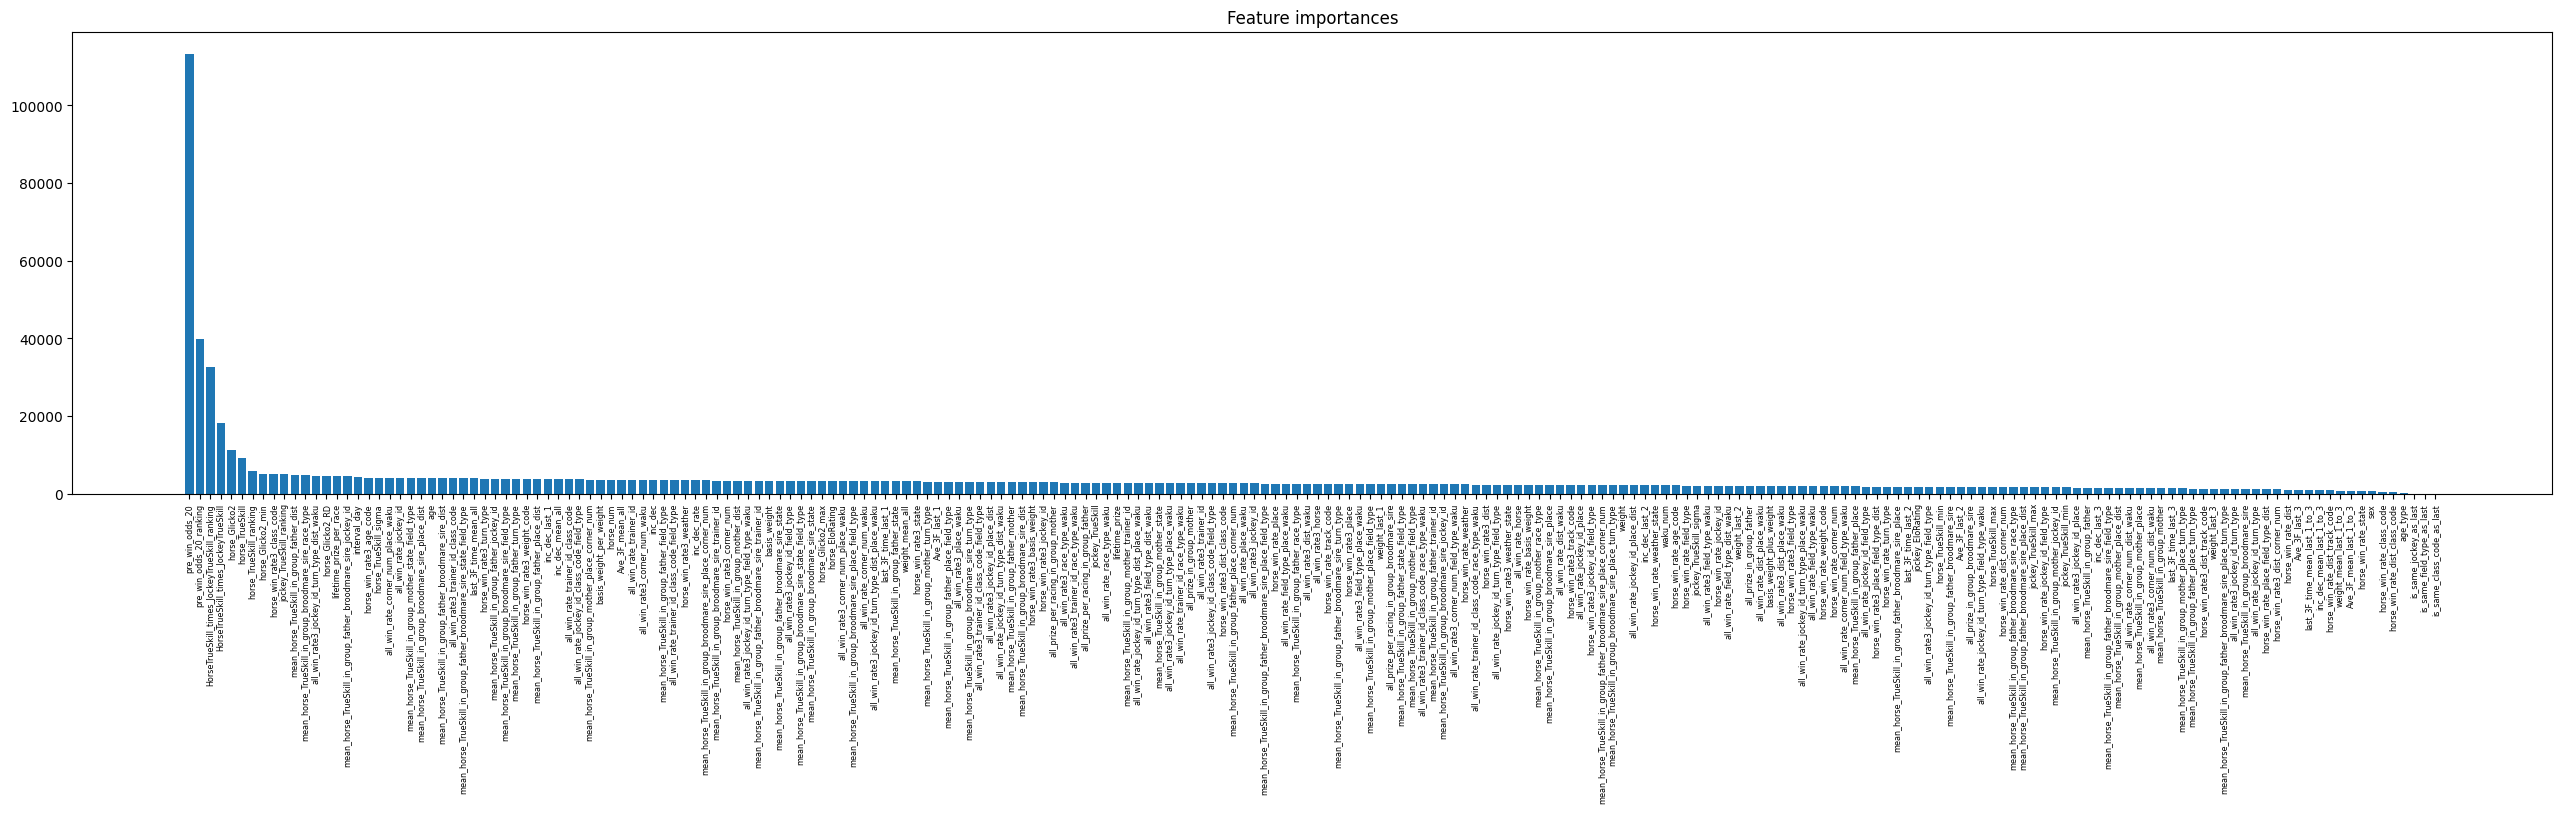

In [72]:
memo = "revise sample weight and calibrated. n_rials=50."
model, df_pred = model_tuner.simple_lightGBM(df4, feature_col2, memo=memo, n_trials=3, save_result=False, visualization=True)

In [73]:
tmp = df_pred[["id_for_fold", "horse", "pred"]].sort_values("pred", ascending=False)
tmp.head(10)

,id_for_fold,horse,pred
233200,2025012506010806,クレーキング,0.684532
223428,2024110308060203,レッドシュテルン,0.606114
235032,2025020805010303,アドマイヤデイトナ,0.579073
222194,2024102608050706,キャピタルサックス,0.577837
221586,2024102008050601,サンダーロード,0.570249
235565,2025020908010407,ギマール,0.539736
222190,2024102605040706,キャネル,0.534265
247879,2025051105020607,シンハナーダ,0.526563
221336,2024101904040506,ゼンダンスカイ,0.512495
246923,2025050408020406,タマモナポリ,0.508921


In [ ]:
df_pred[["id_for_fold", "horse", "pred"]].sort_values("pred", ascending=False).tail()

,id_for_fold,horse,pred
244924,2025042009020805,ディープカインズ,7.756619e-16
248485,2025051708020710,フームスムート,7.573145e-16
250900,2025060705030107,マジョレル,7.337557e-16
240977,2025032207020309,ゲヴァント,7.179513e-16
237121,2025022205010705,ダイユウルージュ,6.751754e-16


In [75]:
df_pred[["race_id", "id_for_fold", "horse", "pred", "win_odds", "target"]].to_csv("df_pred.csv", index=False)

In [91]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

def plot_calibration_curve(df, y_true_col="target", y_pred_col="pred", title="Calibration curve"):
    y_true = df[y_true_col]
    y_pred = df[y_pred_col]

    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=20, strategy='uniform')

    # 件数を計算
    bin_edges = np.linspace(0, 1, 21)  # n_bins+1個のbin境界
    bin_ids = np.digitize(y_pred, bin_edges) - 1 # どのbinに属するか（0～19）

    counts = []
    for i in range(20):
        counts.append(np.sum(bin_ids == i))

    # グラフ描画
    plt.plot(prob_pred, prob_true, marker="o", markersize=4)
    plt.plot([0, 1], [0, 1], linestyle="--", alpha=0.7, color="black")
    plt.xlabel("Predicted Probability")
    plt.ylabel("True Probability")
    plt.title(title)

    # 件数をマーカー上に表示
    for x, y, count in zip(prob_pred, prob_true, counts):
        plt.text(x, y + 0.02, str(count), ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


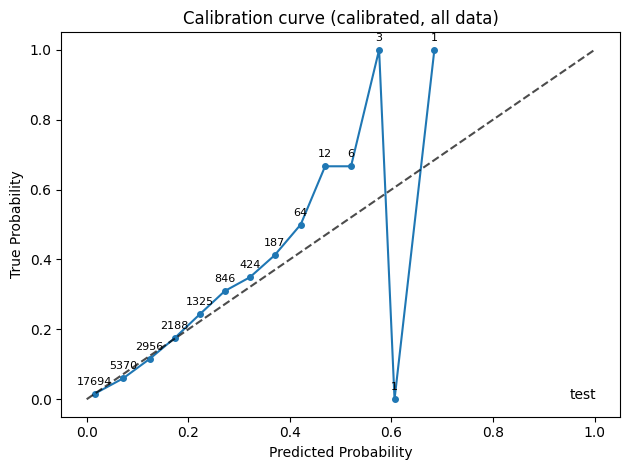

In [90]:
plot_calibration_curve(df_pred, title="Calibration curve (calibrated, all data)")

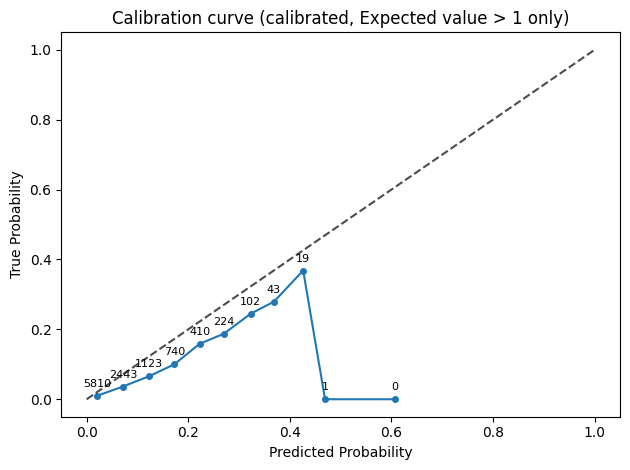

In [80]:
df_pred["exp_value"] = df_pred["win_odds"] * df_pred["pred"]
plot_calibration_curve(df_pred[df_pred["exp_value"] > 1], title="Calibration curve (calibrated, Expected value > 1 only)")